# Policy Briefing Title

## CASA0013: Foundations of Spatial Data Science

### Student Ids: zcfajej, ucfnafk, and ucfnwig

## 1. Research Objective

To identify which MSOAs/wards within London may benefit from an increase of tourist activities using airbnb listings as a metric for attractiveness of location as a tourist destination.

- The idea is to focus more on the relation between variables, and how it present the current situation 

1. Linear Regression

Several hypothesis
- relationship/impact of number of listings to occupancy (availabitily days) per MSOA
- relationship/impact of median price to occupancy (availability days) per MSOA
- relationship/impact of average income to occupancy (availability days) per MSOA
- relationship/impact of population density to occupancy (availability days) per MSOA

2. Clustering

- [low number of listings + high price + low availability] -> high performer/outlier
- [high number of listings + high price + low availability] -> normal or as excpected
- [high number of listings + low price + high availability] -> something wrong happened
- [low number of listings + low price + high availability] -> need help

## 2. Setting Up Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

import statsmodels.formula.api as smf
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

## Set up Caching Function

In [2]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that we don't need to remember to
    do so ourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th time.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split 
        # but it doesn't work with lists... 
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## 3. Load Data

### 3.1 London Middle Super Output Area (MSOA) Shapefile Data

In [3]:
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory

msoas = gpd.read_file( cache_data('http://orca.casa.ucl.ac.uk/~jreades/data/MSOA-2011.gpkg', ddir) )
msoas = msoas.to_crs(epsg=27700)

print("Done.")

Found data/geo/MSOA-2011.gpkg locally!
Done.


In [4]:
#open all columns
pd.set_option('display.max_columns', None)

In [5]:
msoas.head(3)

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.50,4385,1.60,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.30,2713,2.50,"MULTIPOLYGON (((548881.563 190845.265, 548881...."
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.90,3834,2.60,"MULTIPOLYGON (((549102.438 189324.625, 548954...."


In [6]:
msoas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   MSOA11CD   983 non-null    object  
 1   MSOA11NM   983 non-null    object  
 2   LAD11CD    983 non-null    object  
 3   LAD11NM    983 non-null    object  
 4   RGN11CD    983 non-null    object  
 5   RGN11NM    983 non-null    object  
 6   USUALRES   983 non-null    int64   
 7   HHOLDRES   983 non-null    int64   
 8   COMESTRES  983 non-null    int64   
 9   POPDEN     983 non-null    float64 
 10  HHOLDS     983 non-null    int64   
 11  AVHHOLDSZ  983 non-null    float64 
 12  geometry   983 non-null    geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 100.0+ KB


### 3.2 Airbnb Listing Data

In [7]:
host = 'http://orca.casa.ucl.ac.uk'
path = '~jreades/data'

listings = gpd.read_feather( cache_data(f'{host}/{path}/2022-09-10-listings.geofeather', ddir) )
listings = listings.to_crs(epsg=27700)
listings = listings.drop(columns=['index']).set_index('id')
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Found data/geo/2022-09-10-listings.geofeather locally!
Data frame is 68,741 x 31


In [8]:
listings.head(3)

,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_location,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,reviews_per_month,geometry
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13913,https://www.airbnb.com/rooms/13913,2022-09-11,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,Alina,2009-11-16,"London, United Kingdom",False,3,4,"['email', 'phone']",51.57,-0.11,Private room in rental unit,Private room,1,1 shared bath,1.00,1,"[""Extra pillows and blankets"", ""Oven"", ""Fire e...",50.00,1,29,343,30.00,2010-08-18,2022-07-15,4.90,0.20,POINT (530901.013 187213.787)
15400,https://www.airbnb.com/rooms/15400,2022-09-11,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,60302,Philippa,2009-12-05,"Kensington, United Kingdom",False,1,12,"['email', 'phone']",51.49,-0.17,Entire rental unit,Entire home/apt,2,1 bath,1.00,1,"[""Fire extinguisher"", ""Hair dryer"", ""Hangers"",...",75.00,3,50,70,89.00,2009-12-21,2020-03-16,4.79,0.57,POINT (527284.576 178129.679)
284532,https://www.airbnb.com/rooms/284532,2022-09-11,COSY STUDIO-FLAT WITH A GREAT VIEW,My very RECENTLY RENOVATED flat is located in ...,1481412,Luca,2011-12-07,"London, United Kingdom",False,1,3,"['email', 'phone']",51.53,-0.07,Entire rental unit,Entire home/apt,2,1 bath,NaN,2,"[""Extra pillows and blankets"", ""Oven"", ""Cleani...",90.00,5,365,222,42.00,2012-08-19,2022-01-04,4.32,0.34,POINT (533682.377 182823.988)


In [9]:
listings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 68741 entries, 13913 to 554172169432589120
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   listing_url                68741 non-null  object        
 1   last_scraped               68741 non-null  datetime64[ns]
 2   name                       68720 non-null  object        
 3   description                67475 non-null  object        
 4   host_id                    68741 non-null  int64         
 5   host_name                  68741 non-null  object        
 6   host_since                 68741 non-null  datetime64[ns]
 7   host_location              56816 non-null  object        
 8   host_is_superhost          68741 non-null  bool          
 9   host_listings_count        68741 non-null  int64         
 10  host_total_listings_count  68741 non-null  int64         
 11  host_verifications         68741 non-null 

### 3.3 MSOA additional data

Source of MSOA additional data we got from https://data.london.gov.uk/dataset/msoa-atlas
Where some of the variables that we use are:
- house prices (median house prices 2013, Source: Land Registry)
- average income (Total Mean Annual Household Income 2011/2012 (£), Source: Greater London Authority - GLA)
- population density (Persons per hectare (2012), Source: ONS Mid-year estimates)

In [10]:
# read csv msoa data

msoa_data = pd.read_csv( cache_data('https://github.com/hansenwgn/FSDS_group_smartcityzen/raw/main/data/msoadata.csv', 'data'), decimal=',', sep=";" )
print(f"Data frame is {msoa_data.shape[0]:,} x {msoa_data.shape[1]}")

Found data/msoadata.csv locally!
Data frame is 984 x 5


In [11]:
msoa_data.head(3)

,msoa_code,msoa_name,house_prices,average_income,population_density
0,E02000001,City of London 001,"595,000.00","59,728.00",26.20
1,E02000002,Barking and Dagenham 001,"190,000.00","31,788.00",31.70
2,E02000003,Barking and Dagenham 002,"237,000.00","43,357.00",47.70


In [12]:
msoa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   msoa_code           983 non-null    object 
 1   msoa_name           983 non-null    object 
 2   house_prices        983 non-null    float64
 3   average_income      983 non-null    float64
 4   population_density  983 non-null    float64
dtypes: float64(3), object(2)
memory usage: 38.6+ KB


## 4. Data Wrangling / Preparation

### 4.1 Spatial joining MSOA shp + Airbnb listing geofeather
Spatial joining ward shp + gdf 
to get MSOA name for Airbnb Listing data


In [13]:
# Spatial joining
airbnb_msoa = gpd.sjoin(listings,msoas,how="inner", predicate='intersects')

In [14]:
airbnb_msoa.head(3)

,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_location,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,reviews_per_month,geometry,index_right,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13913,https://www.airbnb.com/rooms/13913,2022-09-11,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,Alina,2009-11-16,"London, United Kingdom",False,3,4,"['email', 'phone']",51.57,-0.11,Private room in rental unit,Private room,1,1 shared bath,1.00,1,"[""Extra pillows and blankets"", ""Oven"", ""Fire e...",50.00,1,29,343,30.00,2010-08-18,2022-07-15,4.90,0.20,POINT (530901.013 187213.787),535,E02000556,Islington 003,E09000019,Islington,E12000007,London,10008,9990,18,153.70,4561,2.20
89870,https://www.airbnb.com/rooms/89870,2022-09-11,London Holiday Flat Let-Islington,My comfortable & bright one bedroom flat has a...,54730,Alina,2009-11-16,"London, United Kingdom",False,3,4,"['email', 'phone']",51.57,-0.11,Entire rental unit,Entire home/apt,4,1 bath,1.00,3,"[""Extra pillows and blankets"", ""First aid kit""...",145.00,1,60,343,115.00,2011-08-14,2022-08-28,4.63,0.85,POINT (531003.483 187139.651),535,E02000556,Islington 003,E09000019,Islington,E12000007,London,10008,9990,18,153.70,4561,2.20
958304,https://www.airbnb.com/rooms/958304,2022-09-11,"Charming, Wooden Floors, New Bathroom, nr Tube",Available for 3 weeks during April. Perfect fo...,5213743,Matt & Gemma,2013-02-24,"London, United Kingdom",False,1,1,"['email', 'phone']",51.57,-0.11,Entire rental unit,Entire home/apt,2,1 bath,1.00,1,"[""Wifi"", ""Washer"", ""TV with standard cable"", ""...",110.00,5,21,0,4.00,2013-06-26,2013-12-29,4.75,0.04,POINT (531174.052 186845.833),535,E02000556,Islington 003,E09000019,Islington,E12000007,London,10008,9990,18,153.70,4561,2.20


In [15]:
# Select varibles
airbnb_msoa = airbnb_msoa[['listing_url', 'price', 'availability_365', 'geometry', 'MSOA11CD', 'MSOA11NM']]

In [16]:
airbnb_msoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67988 entries, 13913 to 663811353105819136
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   listing_url       67988 non-null  object  
 1   price             67988 non-null  float64 
 2   availability_365  67988 non-null  int64   
 3   geometry          67988 non-null  geometry
 4   MSOA11CD          67988 non-null  object  
 5   MSOA11NM          67988 non-null  object  
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 3.6+ MB


### 4.2 Joining airbnb_msoa with msoa additional data

In [17]:
# Join geopandas airbnb_msoa with msoa additional data (pandas)

data_combine = airbnb_msoa.merge(msoa_data, left_on='MSOA11CD', right_on='msoa_code', how='left')
data_combine.head(3)

,listing_url,price,availability_365,geometry,MSOA11CD,MSOA11NM,msoa_code,msoa_name,house_prices,average_income,population_density
0,https://www.airbnb.com/rooms/13913,50.00,343,POINT (530901.013 187213.787),E02000556,Islington 003,E02000556,Islington 003,"360,000.00","47,178.00",154.70
1,https://www.airbnb.com/rooms/89870,145.00,343,POINT (531003.483 187139.651),E02000556,Islington 003,E02000556,Islington 003,"360,000.00","47,178.00",154.70
2,https://www.airbnb.com/rooms/958304,110.00,0,POINT (531174.052 186845.833),E02000556,Islington 003,E02000556,Islington 003,"360,000.00","47,178.00",154.70


In [18]:
data_combine.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67988 entries, 0 to 67987
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   listing_url         67988 non-null  object  
 1   price               67988 non-null  float64 
 2   availability_365    67988 non-null  int64   
 3   geometry            67988 non-null  geometry
 4   MSOA11CD            67988 non-null  object  
 5   MSOA11NM            67988 non-null  object  
 6   msoa_code           67988 non-null  object  
 7   msoa_name           67988 non-null  object  
 8   house_prices        67988 non-null  float64 
 9   average_income      67988 non-null  float64 
 10  population_density  67988 non-null  float64 
dtypes: float64(4), geometry(1), int64(1), object(5)
memory usage: 6.2+ MB


### 4.3 Group Data per MSOA

In [19]:
# number of listings per msoa

groupby_listing = data_combine.groupby('msoa_code').listing_url.agg(Count='count').reset_index()
groupby_listing.head()

,msoa_code,Count
0,E02000001,416
1,E02000002,8
2,E02000003,18
3,E02000004,5
4,E02000005,15


In [20]:
groupby_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   msoa_code  982 non-null    object
 1   Count      982 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.5+ KB


In [21]:
# listing price (median) per msoa

groupby_price = data_combine.groupby('msoa_code')['price'].agg('median')
groupby_price.head()

msoa_code
E02000001   196.00
E02000002    50.00
E02000003    72.00
E02000004    52.00
E02000005    82.00
Name: price, dtype: float64

In [22]:
groupby_price.info()

<class 'pandas.core.series.Series'>
Index: 982 entries, E02000001 to E02006931
Series name: price
Non-Null Count  Dtype  
--------------  -----  
982 non-null    float64
dtypes: float64(1)
memory usage: 15.3+ KB


In [23]:
# availability days / occupancy per msoa

groupby_occupancy = data_combine.groupby('msoa_code')['availability_365'].agg('median').reset_index()
groupby_occupancy.head()

,msoa_code,availability_365
0,E02000001,165.00
1,E02000002,243.50
2,E02000003,167.00
3,E02000004,337.00
4,E02000005,349.00


In [24]:
groupby_occupancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   msoa_code         982 non-null    object 
 1   availability_365  982 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.5+ KB


### 4.4 Combine all the group data per msoa

In [25]:
# Join number of listing and listing price

comb1 = groupby_listing.merge(groupby_price, on='msoa_code', how='left')
comb1.head(3)

,msoa_code,Count,price
0,E02000001,416,196.00
1,E02000002,8,50.00
2,E02000003,18,72.00


In [26]:
# Join comb1 with occupancy

comb2 = comb1.merge(groupby_occupancy, on='msoa_code', how='left')
comb2.head(3)

,msoa_code,Count,price,availability_365
0,E02000001,416,196.00,165.00
1,E02000002,8,50.00,243.50
2,E02000003,18,72.00,167.00


In [27]:
# Join comb2 with msoa additional data

comb3 = comb2.merge(msoa_data, on='msoa_code', how='left')
comb3.head(3)

,msoa_code,Count,price,availability_365,msoa_name,house_prices,average_income,population_density
0,E02000001,416,196.00,165.00,City of London 001,"595,000.00","59,728.00",26.20
1,E02000002,8,50.00,243.50,Barking and Dagenham 001,"190,000.00","31,788.00",31.70
2,E02000003,18,72.00,167.00,Barking and Dagenham 002,"237,000.00","43,357.00",47.70


In [28]:
# rename columns
comb3.rename(
    columns={"Count": "number_of_listing", "price": "median_listing_price"},
    inplace=True,
)


In [29]:
comb3.head(3)

,msoa_code,number_of_listing,median_listing_price,availability_365,msoa_name,house_prices,average_income,population_density
0,E02000001,416,196.00,165.00,City of London 001,"595,000.00","59,728.00",26.20
1,E02000002,8,50.00,243.50,Barking and Dagenham 001,"190,000.00","31,788.00",31.70
2,E02000003,18,72.00,167.00,Barking and Dagenham 002,"237,000.00","43,357.00",47.70


In [30]:
# adding occupancy column
comb3['occupancy'] = 365 - comb3['availability_365']

In [31]:
comb3.head(3)

,msoa_code,number_of_listing,median_listing_price,availability_365,msoa_name,house_prices,average_income,population_density,occupancy
0,E02000001,416,196.00,165.00,City of London 001,"595,000.00","59,728.00",26.20,200.00
1,E02000002,8,50.00,243.50,Barking and Dagenham 001,"190,000.00","31,788.00",31.70,121.50
2,E02000003,18,72.00,167.00,Barking and Dagenham 002,"237,000.00","43,357.00",47.70,198.00


In [32]:
# drop availability_365

comb3.drop('availability_365', axis=1, inplace=True)

In [33]:
# rename columns
comb3.rename(
    columns={"occupancy": "occupancy_days_per_year"},
    inplace=True,
)

In [34]:
comb3.head(3)

,msoa_code,number_of_listing,median_listing_price,msoa_name,house_prices,average_income,population_density,occupancy_days_per_year
0,E02000001,416,196.00,City of London 001,"595,000.00","59,728.00",26.20,200.00
1,E02000002,8,50.00,Barking and Dagenham 001,"190,000.00","31,788.00",31.70,121.50
2,E02000003,18,72.00,Barking and Dagenham 002,"237,000.00","43,357.00",47.70,198.00


## 5. Analysis

### 5.1 Regression

#### 5.1.1 Check the correlation between variables

In [35]:
comb3.corr()

,number_of_listing,median_listing_price,house_prices,average_income,population_density,occupancy_days_per_year
number_of_listing,1.00,0.30,0.47,0.29,0.48,0.27
median_listing_price,0.30,1.00,0.38,0.31,0.05,0.02
house_prices,0.47,0.38,1.00,0.78,0.13,0.18
average_income,0.29,0.31,0.78,1.00,-0.08,0.18
population_density,0.48,0.05,0.13,-0.08,1.00,0.41
occupancy_days_per_year,0.27,0.02,0.18,0.18,0.41,1.00


In [36]:
cormat = comb3.drop(['msoa_code', 'msoa_name'], axis=1)

In [37]:
cormat.head(3)

,number_of_listing,median_listing_price,house_prices,average_income,population_density,occupancy_days_per_year
0,416,196.00,"595,000.00","59,728.00",26.20,200.00
1,8,50.00,"190,000.00","31,788.00",31.70,121.50
2,18,72.00,"237,000.00","43,357.00",47.70,198.00


In [38]:
# standardise cormat

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

data_standardised = cormat.copy()
for c in cormat.columns.values:
    data_standardised[c] = mms.fit_transform(cormat[c].values.reshape(-1,1))
data_standardised.head()

,number_of_listing,median_listing_price,house_prices,average_income,population_density,occupancy_days_per_year
0,0.48,0.11,0.14,0.31,0.09,0.55
1,0.01,0.02,0.02,0.08,0.12,0.33
2,0.02,0.03,0.03,0.18,0.18,0.54
3,0.00,0.02,0.02,0.20,0.09,0.07
4,0.02,0.04,0.01,0.10,0.28,0.04


Text(0.5, 1.0, 'Correlation Matrix')

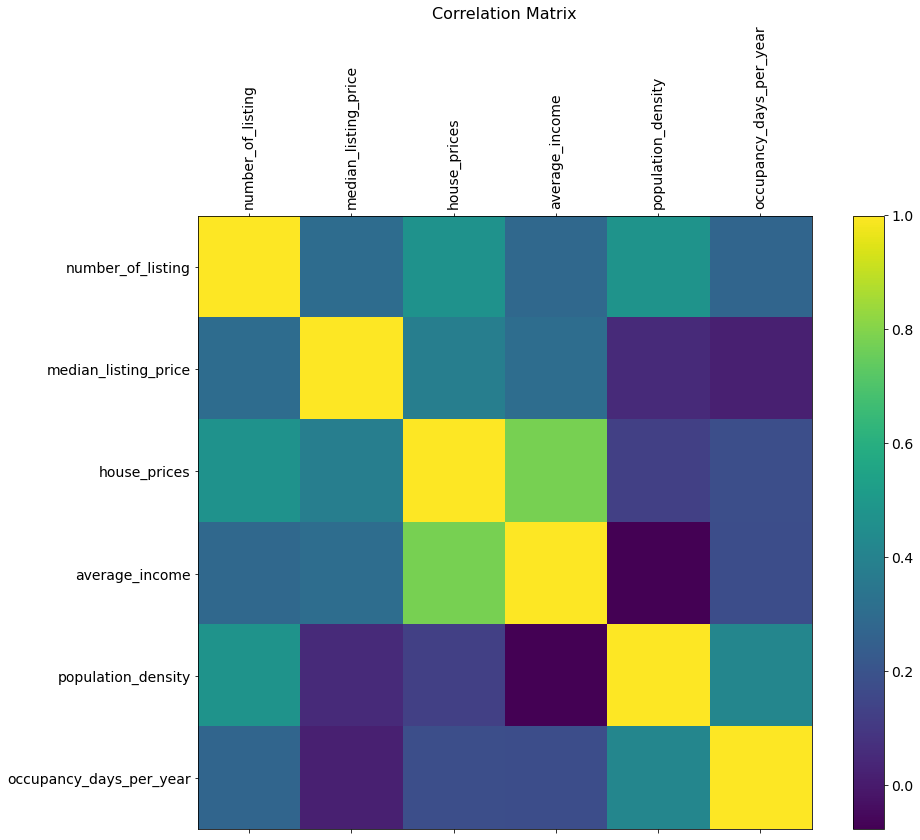

In [39]:
# Correlation Matrix

plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(15, 11))
plt.matshow(cormat.corr(), fignum=f.number)
plt.xticks(range(cormat.shape[1]), cormat.columns, fontsize=14, rotation=90)
plt.yticks(range(cormat.shape[1]), cormat.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

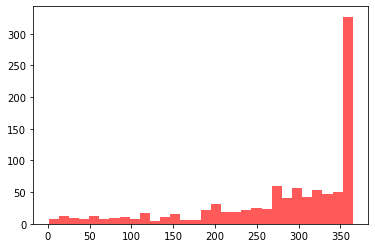

In [40]:
# Check distribution plot

# plotting histogram
plt.hist(comb3['occupancy_days_per_year'],bins = 30,
         alpha = 0.65, color = 'red')
plt.show()

#### 5.1.2 Scatter Plot

<AxesSubplot:xlabel='house_prices', ylabel='occupancy_days_per_year'>

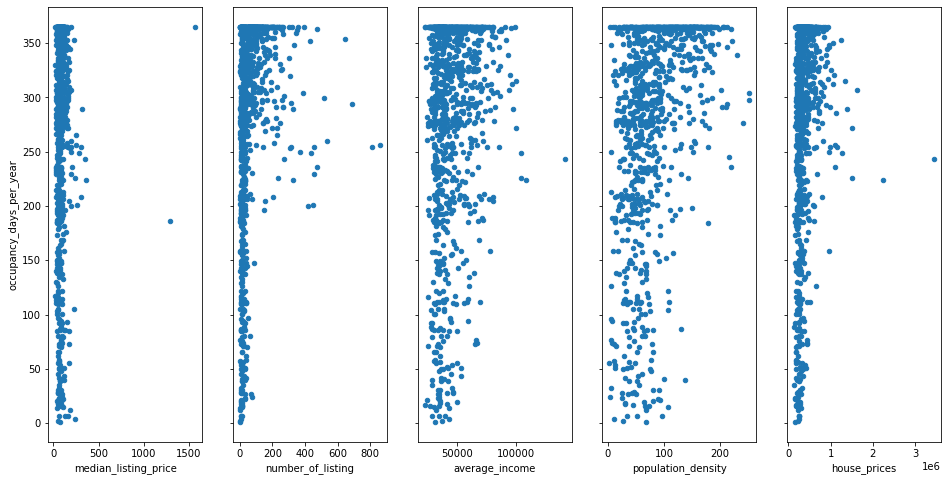

In [41]:
fig, axs = plt.subplots(1, 5, sharey=True)
comb3.plot(kind='scatter', x='median_listing_price', y='occupancy_days_per_year', ax=axs[0], figsize=(16, 8))
comb3.plot(kind='scatter', x='number_of_listing', y='occupancy_days_per_year', ax=axs[1])
comb3.plot(kind='scatter', x='average_income', y='occupancy_days_per_year', ax=axs[2])
comb3.plot(kind='scatter', x='population_density', y='occupancy_days_per_year', ax=axs[3])
comb3.plot(kind='scatter', x='house_prices', y='occupancy_days_per_year', ax=axs[4])


#### 5.1.3 Calculate VIF

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features):
    
    X = comb3[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
        
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

compute_vif(['median_listing_price','number_of_listing', 'average_income','population_density', 'house_prices'])

/tmp/ipykernel_24835/3666854684.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,median_listing_price,1.21
1,number_of_listing,1.72
2,average_income,2.79
3,population_density,1.41
4,house_prices,3.23


#### 5.1.4 Multiple Regression

In [43]:
# Data Prep for Regression

reg_df = comb3.copy(deep=True)
reg_df.head(3)

,msoa_code,number_of_listing,median_listing_price,msoa_name,house_prices,average_income,population_density,occupancy_days_per_year
0,E02000001,416,196.00,City of London 001,"595,000.00","59,728.00",26.20,200.00
1,E02000002,8,50.00,Barking and Dagenham 001,"190,000.00","31,788.00",31.70,121.50
2,E02000003,18,72.00,Barking and Dagenham 002,"237,000.00","43,357.00",47.70,198.00


In [44]:
# ln average income

reg_df['average_income'] = np.log(reg_df['average_income'])


In [45]:
# ln house prices

reg_df['house_prices'] = np.log(reg_df['house_prices'])

In [46]:
reg_df.head(3)

,msoa_code,number_of_listing,median_listing_price,msoa_name,house_prices,average_income,population_density,occupancy_days_per_year
0,E02000001,416,196.00,City of London 001,13.30,11.00,26.20,200.00
1,E02000002,8,50.00,Barking and Dagenham 001,12.15,10.37,31.70,121.50
2,E02000003,18,72.00,Barking and Dagenham 002,12.38,10.68,47.70,198.00


In [47]:
model_reg = smf.ols('occupancy_days_per_year ~ median_listing_price + number_of_listing + average_income + population_density + house_prices', 
                        reg_df).fit()
model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     occupancy_days_per_year   R-squared:                       0.232
Model:                                 OLS   Adj. R-squared:                  0.228
Method:                      Least Squares   F-statistic:                     59.03
Date:                     Sat, 14 Jan 2023   Prob (F-statistic):           9.35e-54
Time:                             14:17:56   Log-Likelihood:                -5738.5
No. Observations:                      982   AIC:                         1.149e+04
Df Residuals:                          976   BIC:                         1.152e+04
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -624.5430    103.921     -6.010      0.000    -828.478    -420.608
median_listing_price    -0.1227      0.040     -3.055      0.002      -0.202      -0.044
number_of_listing        0.0017      0.039      0.043      0.966      -0.075       0.078
average_income          47.7732     16.187      2.951      0.003      16.009      79.538
population_density       0.8067      0.067     12.073      0.000       0.676       0.938
house_prices            26.6013     12.781      2.081      0.038       1.519      51.683
==============================================================================
Omnibus:                      108.709   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.585
Skew:                          -0.897   Prob(JB):                     6.62e-32
Kurtosis:                       3.541   Cond. No.                     6.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 5.2 Clustering

K-Means eucledian distance, sensitive with outliers, formula use quadrat square. How we include outlier, we use binning

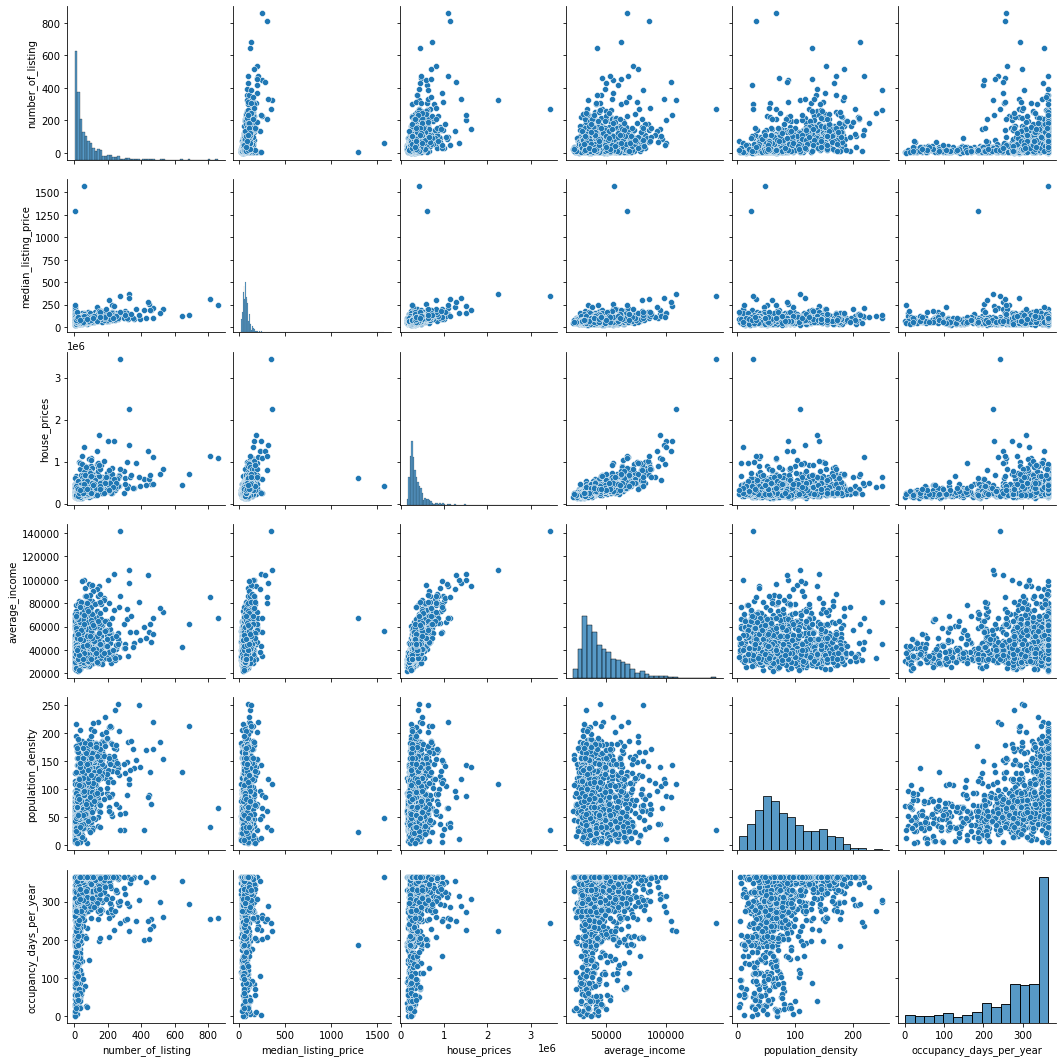

In [48]:
# See distribution plot

sns.pairplot(comb3)

In [49]:
# Binning instead of normalisation, to include the outlier. Not pull the centroid
# justification outlier make some group
#bins = [0, 100, 200, 300, 400, 500, 600, 1000]
#labels = [1,2,3,4,5,6,10]
#comb3['binned_number_of_listing'] = pd.cut(comb3['number_of_listing'], bins=bins, labels=labels)
#comb3.head(3)

In [50]:
# Copy comb3
#comb3norm = comb3.copy(deep=True)

In [51]:
#comb3norm.head(3)

In [52]:
# standardise comb3
#from sklearn.preprocessing import StandardScaler


#cols_to_norm = ['number_of_listing','median_listing_price', 'house_prices', 'average_income', 'population_density', 'occupancy_days_per_year']
#comb3norm[cols_to_norm] = StandardScaler().fit_transform(comb3norm[cols_to_norm])

In [53]:
#comb3norm.head(3)

In [54]:
#comb3.head(3)

In [55]:
# Data Prep for Clustering

cluster_df = comb3.copy(deep=True)
cluster_df.head(3)


,msoa_code,number_of_listing,median_listing_price,msoa_name,house_prices,average_income,population_density,occupancy_days_per_year
0,E02000001,416,196.00,City of London 001,"595,000.00","59,728.00",26.20,200.00
1,E02000002,8,50.00,Barking and Dagenham 001,"190,000.00","31,788.00",31.70,121.50
2,E02000003,18,72.00,Barking and Dagenham 002,"237,000.00","43,357.00",47.70,198.00


In [56]:
# standardise cluster_df
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

columns = ['number_of_listing','median_listing_price', 'house_prices', 'average_income', 'population_density', 'occupancy_days_per_year']

cluster_df[columns] = mms.fit_transform(cluster_df[columns])
cluster_df.head(3)

,msoa_code,number_of_listing,median_listing_price,msoa_name,house_prices,average_income,population_density,occupancy_days_per_year
0,E02000001,0.48,0.11,City of London 001,0.14,0.31,0.09,0.55
1,E02000002,0.01,0.02,Barking and Dagenham 001,0.02,0.08,0.12,0.33
2,E02000003,0.02,0.03,Barking and Dagenham 002,0.03,0.18,0.18,0.54


In [57]:
cluster_df.drop(['msoa_name', 'number_of_listing'], axis=1, inplace=True)

In [58]:
cluster_df.head(3)

,msoa_code,median_listing_price,house_prices,average_income,population_density,occupancy_days_per_year
0,E02000001,0.11,0.14,0.31,0.09,0.55
1,E02000002,0.02,0.02,0.08,0.12,0.33
2,E02000003,0.03,0.03,0.18,0.18,0.54


In [59]:
cluster_df.set_index('msoa_code', inplace=True)

In [60]:
cluster_df.head(3)

,median_listing_price,house_prices,average_income,population_density,occupancy_days_per_year
msoa_code,,,,,
E02000001,0.11,0.14,0.31,0.09,0.55
E02000002,0.02,0.02,0.08,0.12,0.33
E02000003,0.03,0.03,0.18,0.18,0.54


In [61]:
from sklearn.cluster import KMeans

In [62]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [63]:
kmeans.fit(cluster_df)

KMeans(init='random', n_clusters=3, random_state=42)

In [64]:
kmeans.cluster_centers_

array([[0.03931358, 0.07126148, 0.21566748, 0.22960263, 0.85240086],
       [0.04529874, 0.08464169, 0.19478123, 0.56946185, 0.94350408],
       [0.03867529, 0.04284407, 0.16034299, 0.19392919, 0.34383423]])

In [65]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2,
       2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2,
       2, 0, 0, 2, 2, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0,
       2, 0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2,

In [66]:
cluster_df['cluster'] = pd.Series(kmeans.labels_, index=cluster_df.index)

In [67]:
cluster_df['cluster'] = cluster_df['cluster'] + 1

In [68]:
cluster_df.head(10)

,median_listing_price,house_prices,average_income,population_density,occupancy_days_per_year,cluster
msoa_code,,,,,,
E02000001,0.11,0.14,0.31,0.09,0.55,3
E02000002,0.02,0.02,0.08,0.12,0.33,3
E02000003,0.03,0.03,0.18,0.18,0.54,3
E02000004,0.02,0.02,0.20,0.09,0.07,3
E02000005,0.04,0.01,0.10,0.28,0.04,3
E02000007,0.02,0.01,0.06,0.20,0.18,3
E02000008,0.08,0.01,0.08,0.32,0.70,1
E02000009,0.06,0.01,0.08,0.36,0.50,3
E02000010,0.02,0.01,0.08,0.31,0.91,1


In [69]:
# How many cluster - Using Silhouette 
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

In [70]:
# Copy df
cluster_df2 = cluster_df.copy(deep=True)
cluster_df2.head(3)

,median_listing_price,house_prices,average_income,population_density,occupancy_days_per_year,cluster
msoa_code,,,,,,
E02000001,0.11,0.14,0.31,0.09,0.55,3
E02000002,0.02,0.02,0.08,0.12,0.33,3
E02000003,0.03,0.03,0.18,0.18,0.54,3


In [71]:
cluster_df2.drop('cluster', axis=1, inplace=True)

In [72]:
cluster_df2.head(3)

,median_listing_price,house_prices,average_income,population_density,occupancy_days_per_year
msoa_code,,,,,
E02000001,0.11,0.14,0.31,0.09,0.55
E02000002,0.02,0.02,0.08,0.12,0.33
E02000003,0.03,0.03,0.18,0.18,0.54


In [73]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cluster_df2)
    score = silhouette_score(cluster_df2, kmeans.labels_)
    silhouette_coefficients.append(score)

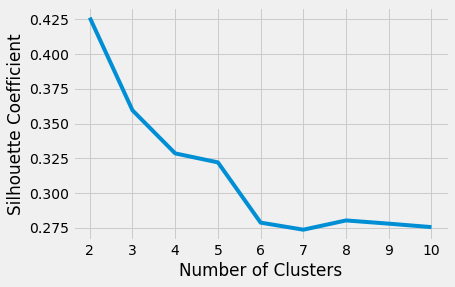

In [74]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [75]:
#Elbow method
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cluster_df2)
    sse.append(kmeans.inertia_)

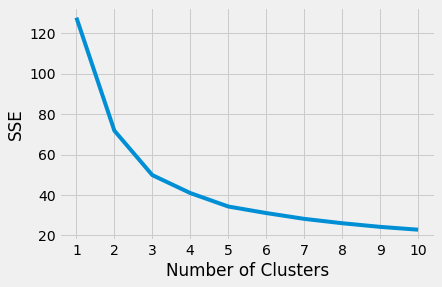

In [76]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [77]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

In [78]:
# Joining with shp file
cluster_shp = pd.merge(msoas, cluster_df, left_on='MSOA11CD', right_on='msoa_code')
cluster_shp.head(3)


,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,median_listing_price,house_prices,average_income,population_density,occupancy_days_per_year,cluster
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.50,4385,1.60,"MULTIPOLYGON (((531667.624 180534.992, 531647....",0.11,0.14,0.31,0.09,0.55,3
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.30,2713,2.50,"MULTIPOLYGON (((548881.563 190845.265, 548881....",0.02,0.02,0.08,0.12,0.33,3
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.90,3834,2.60,"MULTIPOLYGON (((549102.438 189324.625, 548954....",0.03,0.03,0.18,0.18,0.54,3


In [79]:
cluster_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 982 entries, 0 to 981
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   MSOA11CD                 982 non-null    object  
 1   MSOA11NM                 982 non-null    object  
 2   LAD11CD                  982 non-null    object  
 3   LAD11NM                  982 non-null    object  
 4   RGN11CD                  982 non-null    object  
 5   RGN11NM                  982 non-null    object  
 6   USUALRES                 982 non-null    int64   
 7   HHOLDRES                 982 non-null    int64   
 8   COMESTRES                982 non-null    int64   
 9   POPDEN                   982 non-null    float64 
 10  HHOLDS                   982 non-null    int64   
 11  AVHHOLDSZ                982 non-null    float64 
 12  geometry                 982 non-null    geometry
 13  median_listing_price     982 non-null    float64 
 14  ho

In [80]:
cluster_shp['cluster'] = cluster_shp['cluster'].astype(str)

In [81]:
cluster_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 982 entries, 0 to 981
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   MSOA11CD                 982 non-null    object  
 1   MSOA11NM                 982 non-null    object  
 2   LAD11CD                  982 non-null    object  
 3   LAD11NM                  982 non-null    object  
 4   RGN11CD                  982 non-null    object  
 5   RGN11NM                  982 non-null    object  
 6   USUALRES                 982 non-null    int64   
 7   HHOLDRES                 982 non-null    int64   
 8   COMESTRES                982 non-null    int64   
 9   POPDEN                   982 non-null    float64 
 10  HHOLDS                   982 non-null    int64   
 11  AVHHOLDSZ                982 non-null    float64 
 12  geometry                 982 non-null    geometry
 13  median_listing_price     982 non-null    float64 
 14  ho

<AxesSubplot:>

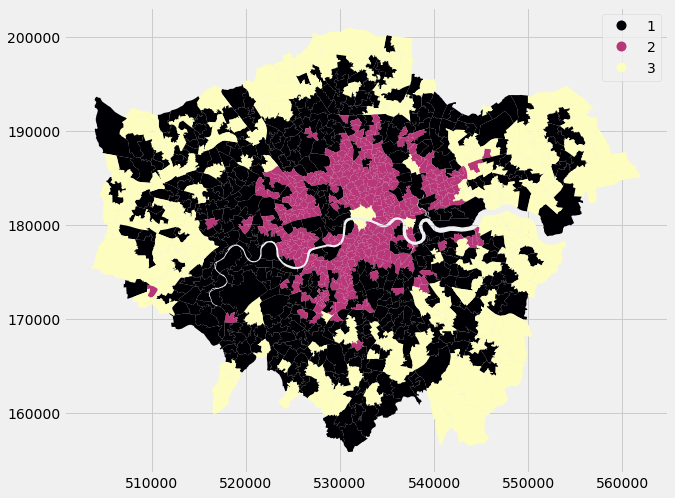

In [82]:
# Plotting
cluster_shp.plot(column='cluster', cmap='magma', edgecolor='none', legend=True, figsize=(12,8))

## Interpretation
1. Black: clusters with relatively high occupancy, with relatively high listing and housing prices. Not a very central area, and the population density is not that high. It is a regional cluster (MSOA) that has the highest average income
2. Pink: the cluster with the highest occupancy. Even though the listing price, and house prices are high, this area cluster is quite central and has many interesting places for tourism, and the population density is the highest.
3. Yellow: the cluster with the lowest occupancy and also a low population density. Not an expensive area, has the lowest average house prices. The listing price is quite similar to cluster 1 but it is not a central and tourist area so occupancy is low.

In [83]:
cluster_df.groupby("cluster").mean()

,median_listing_price,house_prices,average_income,population_density,occupancy_days_per_year
cluster,,,,,
1,0.04,0.07,0.22,0.23,0.85
2,0.05,0.08,0.19,0.57,0.94
3,0.04,0.04,0.16,0.19,0.34
